Data from: https://fermi.gsfc.nasa.gov/ssc/data/access/

Source info: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=PG+1553%2B113

In [1]:
import astropy
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle as LS

Let's read the table

In [2]:
# Read  data
bl = astropy.io.ascii.read('lc_4FGLJ1555.7p1111.dmp1.out',data_start=3)
# time
mjd = bl['col1']
# flux
fl = bl['col2']
efl = bl['col3']
#

In [3]:
dmean = np.mean(fl)
print('Mean flux (arbitrary units): ', dmean)

Mean flux (arbitrary units):  2.101955302923227e-07


In [4]:
fl = fl*1e7
efl = efl*1e7

Data are equally spaced so we can carry out the analysis with both regular DFT or Lombs-Scargle algorithm.

Let's define a simple DFT function:

In [5]:
def FourierPeriodogram(t, y):
    N = len(t)
    step = t[1] - t[0]
    frequency = np.fft.fftfreq(N, step)
    y_fft = np.fft.fft(y)
    positive = (frequency > 0)
    return frequency[positive], (1./N) * abs(y_fft[positive]) ** 2

Let's give a look at the light curve. Please remeber that fuxes are in arbitrary units.

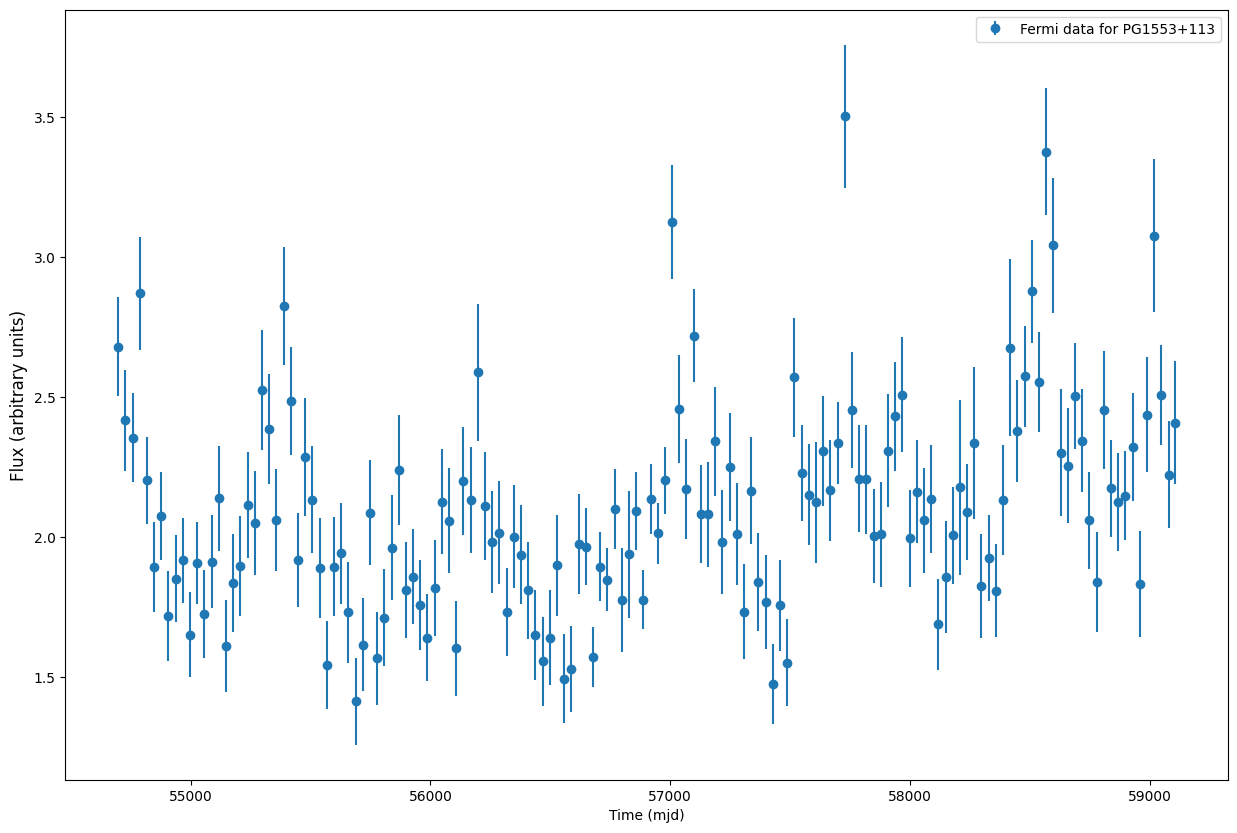

In [6]:
p = plt.figure(figsize=(15,10))
plt.errorbar(mjd,fl,yerr=efl,fmt='o',label='Fermi data for PG1553+113')
plt.legend()
plt.ylabel("Flux (arbitrary units)",fontsize='large')
plt.xlabel("Time (mjd)")
plt.show()


A general regularity in showing epochs with higher or lower flux is visible. Let's see if it can be better quantified.

Let's compute the Fourier Transform (on the data centered to 0):

In [7]:
freqf,powerf = FourierPeriodogram(mjd,fl)

And let's compute a LS periodogram on the same frequency grid without considerign the errors:

In [8]:
powerLS = LS(mjd,fl).power(freqf,normalization='psd')

And again a LS period including the errors in the analysis.

In [15]:
powerLSe = LS(mjd,fl,efl).power(freqf,normalization='psd')

And let's see visually the results. Please, consider that DFT ans LS has the same units only if errors are not specified. If errors are not included in the analysis power units become "square of flux units". In the following plot the scale factor has been found by trial and errors.

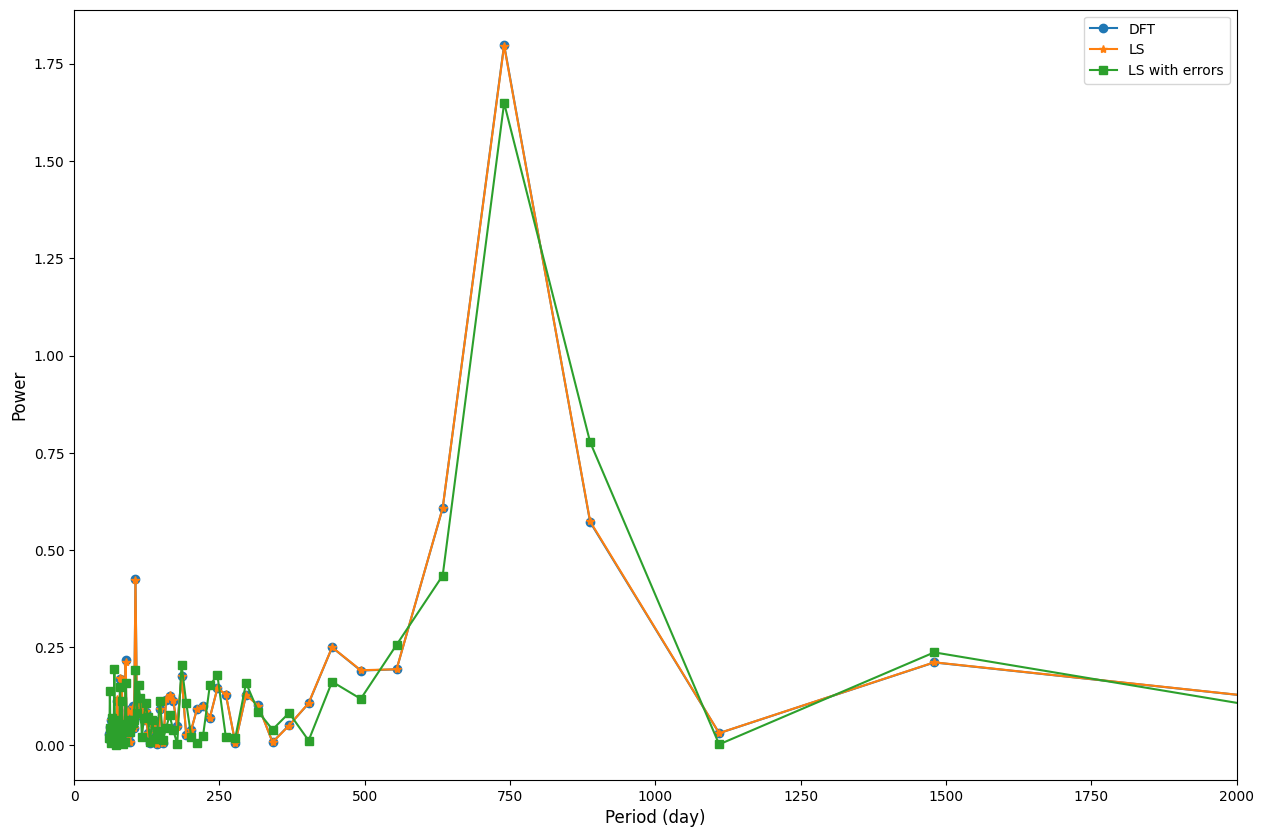

In [16]:
p = plt.figure(figsize=(15,10))
plt.plot(1./freqf,powerf,'o-',label='DFT')
plt.plot(1./freqf,powerLS,'*-',label='LS')
plt.plot(1./freqf,powerLSe/30,'s-',label='LS with errors')
plt.legend()
plt.xlabel("Period (day)",fontsize='large')
plt.ylabel("Power",fontsize='large')
plt.xlim((0,2000))
plt.show()

As expected, the DFT and LS are indistinguishable, while errors modify (slightly, in this case) the periodogram. There is a huge peak close to 800 days. We can hope to better model it using more frequencies beyond the Fourier frequency grid. This is trivial with the LS.

In [17]:
snmean = np.mean(fl/efl)
print ("Mean S/N:", snmean)

Mean S/N: 11.755740325756205


In [18]:
ls = LS(mjd,fl,efl)
freq,power = ls.autopower(nyquist_factor=1,samples_per_peak=10)

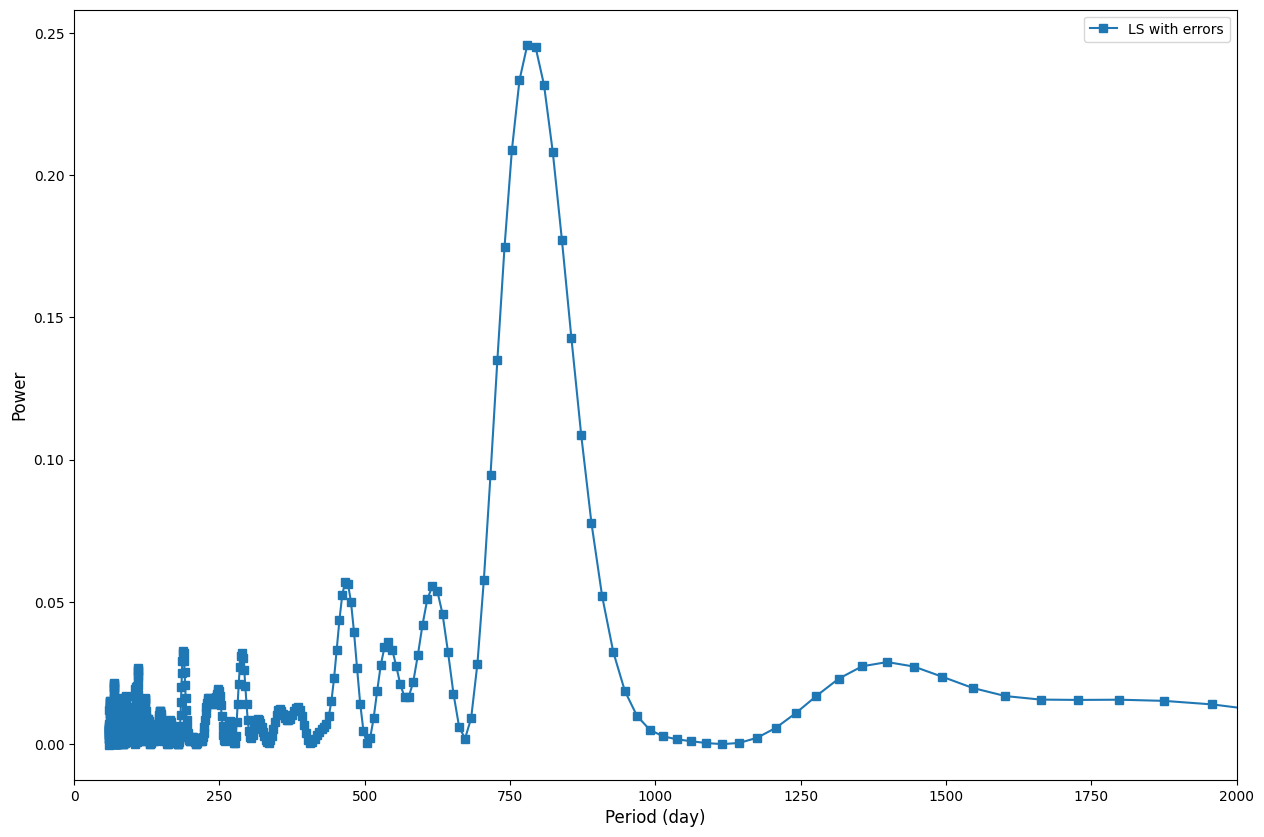

In [19]:
p = plt.figure(figsize=(15,10))
plt.plot(1./freq,power,'s-',label='LS with errors')
plt.legend()
plt.xlabel("Period (day)",fontsize='large')
plt.ylabel("Power",fontsize='large')
plt.xlim((0,2000))
plt.show()

Clearly the periodpgram is now much better defined.
So, is the peak big enough to think this is a real periodicity? We can first compute its false alarm probability.

In [20]:
print("FAP: ", ls.false_alarm_probability(power.max()))

FAP:  2.326644174127485e-06


It looks amazing. However, if we plot the periodogran with logarithmic axes we see this is not the case.

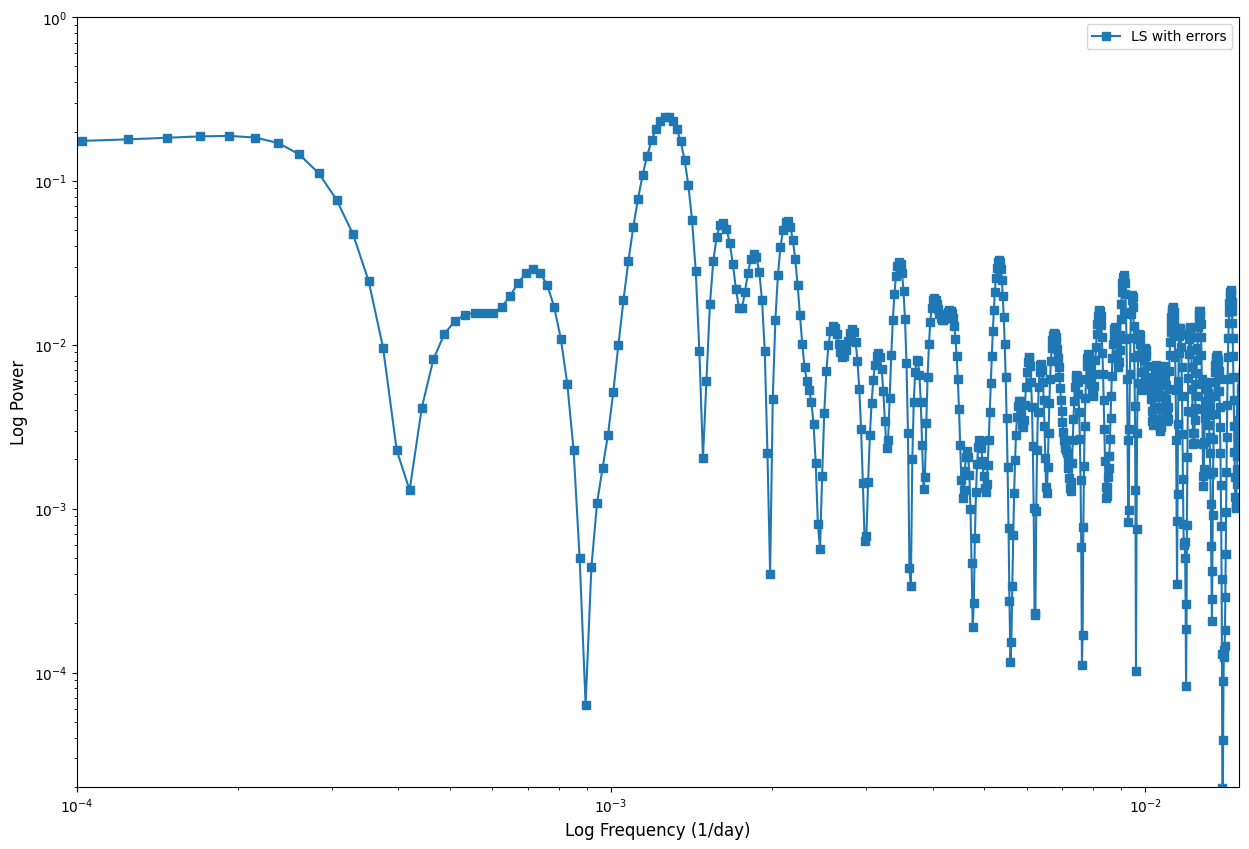

In [21]:
p = plt.figure(figsize=(15,10))
plt.plot(freq,power,'s-',label='LS with errors')
plt.legend()
plt.xlabel("Log Frequency (1/day)",fontsize='large')
plt.ylabel("Log Power",fontsize='large')
plt.xlim((1e-4,1.5e-2))
plt.ylim((2e-5,1))
plt.loglog()
plt.show()

And it is now clear that we have a global trend in increasing power going to lower frequencies. A typical correlated noise behavior requiring a substabtially more complex analysis.

### Bayesian Lomb-Scargle

Let's study no the Bayesian interpretation of the LS periodogram. And let's not forget that it is based on strong assumptions.

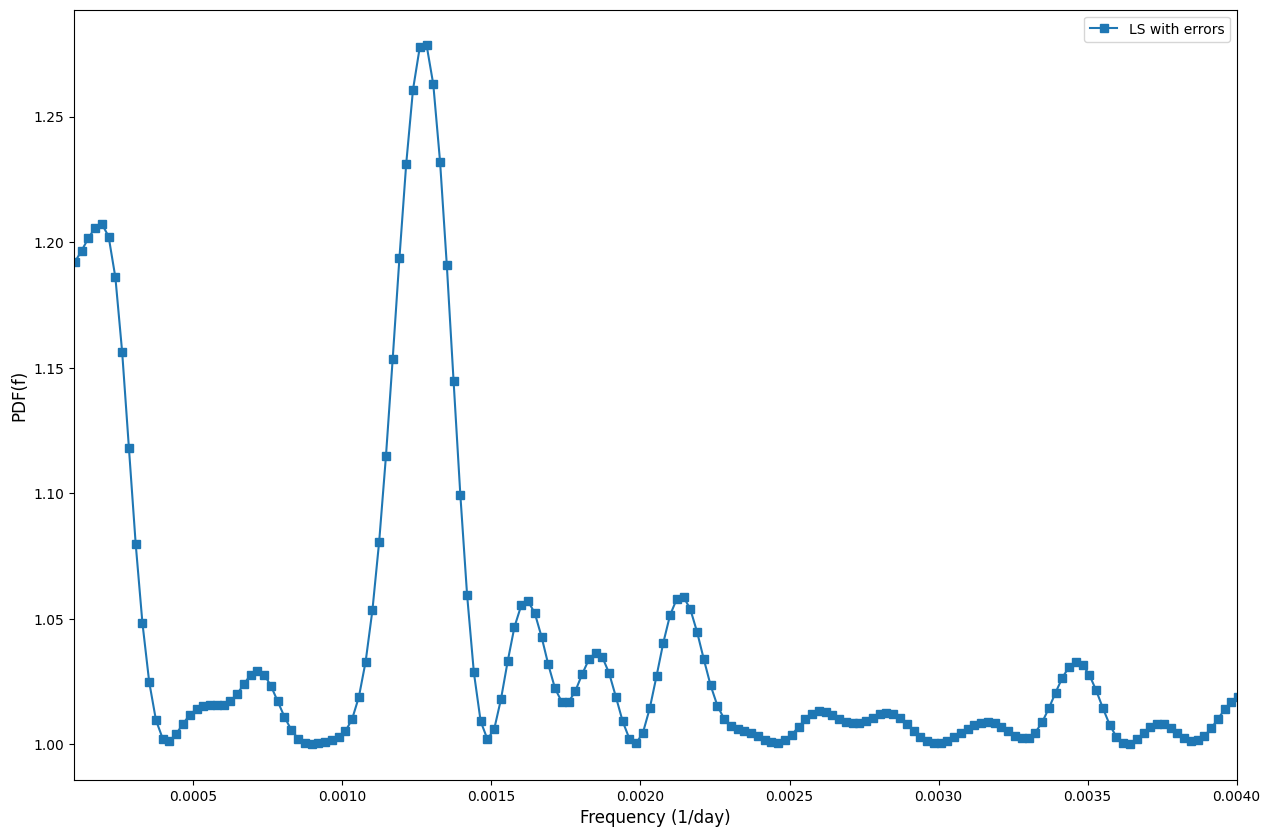

In [22]:
p = plt.figure(figsize=(15,10))
plt.plot(freq,np.exp(power),'s-',label='LS with errors')
plt.legend()
plt.xlabel("Frequency (1/day)",fontsize='large')
plt.ylabel("PDF(f)",fontsize='large')
plt.xlim((1e-4,4e-3))
plt.show()

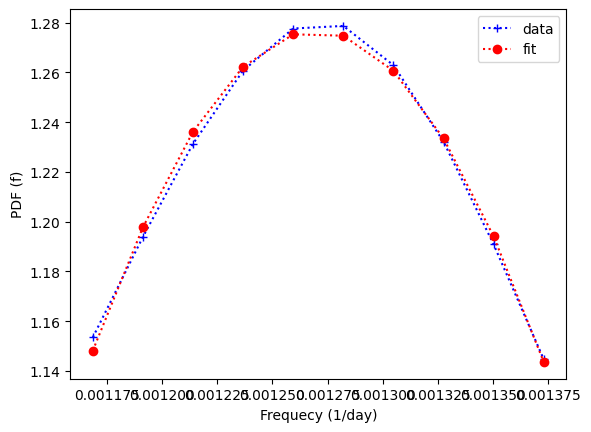

Period: 787 +/- 67 days


In [23]:
from scipy.optimize import curve_fit


#MINFRQ = 0.001
#MAXFRQ = 0.0015

MINFRQ = 0.00115
MAXFRQ = 0.00138


slct = (freq > MINFRQ) & (freq < MAXFRQ)
x = freq[slct]
y = np.exp(power)[slct]

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

#popt,pcov = curve_fit(gaus,x,y)
popt,pcov = curve_fit(gaus,x,y,p0=[1,0.0012,0.0002])

plt.plot(x,y,'b+:',label='data')
plt.plot(x,gaus(x,*popt),'ro:',label='fit')
plt.legend()
plt.xlabel('Frequecy (1/day)')
plt.ylabel('PDF (f)')
plt.show()

print(r"Period: {:.0f} +/- {:.0f} days".format(1/popt[1],np.sqrt(1/popt[2])))